In [1]:
import os
import numpy as np
import torch
import pyedflib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F

# 고정 설정
sampling_rate = 256
segment_length = 30 * sampling_rate
label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"


In [2]:
def load_data_from_sn(sn_list):
    all_segments = []
    all_labels = []

    for sn in sn_list:
        base = f"SN{sn:03d}"
        ecg_path = os.path.join(root_dir, f"{base}.edf")
        label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")

        if not os.path.exists(ecg_path) or not os.path.exists(label_path):
            print(f"❌ 파일 없음: {base}")
            continue

        try:
            ecg_reader = pyedflib.EdfReader(ecg_path)
            ecg_signal = ecg_reader.readSignal(7)
        finally:
            ecg_reader._close()

        try:
            label_reader = pyedflib.EdfReader(label_path)
            annotations = label_reader.readAnnotations()
        finally:
            label_reader._close()

        onsets, durations, labels = annotations
        label_seq = []
        for i in range(len(labels)):
            label_str = labels[i].decode() if isinstance(labels[i], bytes) else labels[i]
            if label_str in label_map:
                label_index = label_map[label_str]
                num_segments = int(durations[i] // 30)
                label_seq.extend([label_index] * num_segments)

        max_segments = len(ecg_signal) // segment_length
        num_segments = min(len(label_seq), max_segments)

        for i in range(num_segments):
            start = i * segment_length
            end = start + segment_length
            segment = ecg_signal[start:end]
            all_segments.append(segment)
            all_labels.append(label_seq[i])

    X = torch.tensor(np.array(all_segments), dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y


In [3]:
from collections import Counter
import numpy as np
import torch

def load_balanced_data_from_sn(sn_list):
    all_segments = []
    all_labels = []

    for sn in sn_list:
        try:
            X, y = load_data_from_sn([sn])  # SN 하나만 불러옴
        except Exception as e:
            print(f"❌ SN{sn:03d} 불러오기 실패: {e}")
            continue

        if len(y) == 0:
            print(f"⚠️ SN{sn:03d}: 라벨 없음 → 건너뜀")
            continue

        y_np = y.numpy()
        X_np = X.numpy()

        label_counts = Counter(y_np)
        if len(label_counts) < 2:
            print(f"⚠️ SN{sn:03d}: 라벨 다양성 부족 → 건너뜀")
            continue

        min_count = min(label_counts.values())
        indices = []

        for label in sorted(label_counts.keys()):
            label_indices = np.where(y_np == label)[0]
            if len(label_indices) < min_count:
                continue
            sampled = np.random.choice(label_indices, min_count, replace=False)
            indices.extend(sampled)

        if not indices:
            print(f"⚠️ SN{sn:03d}: 유효한 샘플 없음 → 건너뜀")
            continue

        np.random.shuffle(indices)
        all_segments.append(X_np[indices])
        all_labels.append(y_np[indices])

        print(f"✅ SN{sn:03d} 처리 완료: 클래스당 {min_count}개")

    if not all_segments:
        raise ValueError("⚠️ 유효한 데이터가 없습니다. SN 목록을 다시 확인하세요.")

    X_all = torch.tensor(np.concatenate(all_segments), dtype=torch.float32)
    y_all = torch.tensor(np.concatenate(all_labels), dtype=torch.long)
    return X_all, y_all


In [4]:
X_train, y_train = load_balanced_data_from_sn(list(range(1, 94)))  # SN001 ~ SN093
X_val, y_val = load_balanced_data_from_sn(list(range(94, 124)))   # SN094 ~ SN123
X_test, y_test = load_data_from_sn(list(range(124, 154)))

✅ SN001 처리 완료: 클래스당 23개


✅ SN002 처리 완료: 클래스당 82개


✅ SN003 처리 완료: 클래스당 150개


✅ SN004 처리 완료: 클래스당 64개


✅ SN005 처리 완료: 클래스당 127개


✅ SN006 처리 완료: 클래스당 65개


✅ SN007 처리 완료: 클래스당 67개


✅ SN008 처리 완료: 클래스당 39개


✅ SN009 처리 완료: 클래스당 91개


✅ SN010 처리 완료: 클래스당 101개


✅ SN011 처리 완료: 클래스당 37개


✅ SN012 처리 완료: 클래스당 184개


✅ SN013 처리 완료: 클래스당 65개
❌ 파일 없음: SN014
⚠️ SN014: 라벨 없음 → 건너뜀


✅ SN015 처리 완료: 클래스당 102개


✅ SN016 처리 완료: 클래스당 24개


✅ SN017 처리 완료: 클래스당 96개


✅ SN018 처리 완료: 클래스당 19개


✅ SN019 처리 완료: 클래스당 72개


✅ SN020 처리 완료: 클래스당 67개


✅ SN021 처리 완료: 클래스당 156개


✅ SN022 처리 완료: 클래스당 115개


✅ SN023 처리 완료: 클래스당 74개


✅ SN024 처리 완료: 클래스당 70개


✅ SN025 처리 완료: 클래스당 106개


✅ SN026 처리 완료: 클래스당 127개


✅ SN027 처리 완료: 클래스당 19개


✅ SN028 처리 완료: 클래스당 136개


✅ SN029 처리 완료: 클래스당 59개


✅ SN030 처리 완료: 클래스당 108개


✅ SN031 처리 완료: 클래스당 74개


✅ SN032 처리 완료: 클래스당 133개
✅ SN033 처리 완료: 클래스당 47개


✅ SN034 처리 완료: 클래스당 75개


✅ SN035 처리 완료: 클래스당 108개


✅ SN036 처리 완료: 클래스당 87개


✅ SN037 처리 완료: 클래스당 65개


✅ SN038 처리 완료: 클래스당 61개


✅ SN039 처리 완료: 클래스당 108개


✅ SN040 처리 완료: 클래스당 62개


✅ SN041 처리 완료: 클래스당 130개


✅ SN042 처리 완료: 클래스당 148개


✅ SN043 처리 완료: 클래스당 56개


✅ SN044 처리 완료: 클래스당 55개


✅ SN045 처리 완료: 클래스당 129개


✅ SN046 처리 완료: 클래스당 49개


✅ SN047 처리 완료: 클래스당 125개


✅ SN048 처리 완료: 클래스당 146개


✅ SN049 처리 완료: 클래스당 41개


✅ SN050 처리 완료: 클래스당 25개


✅ SN051 처리 완료: 클래스당 84개


✅ SN052 처리 완료: 클래스당 59개


✅ SN053 처리 완료: 클래스당 163개
✅ SN054 처리 완료: 클래스당 28개


✅ SN055 처리 완료: 클래스당 115개


✅ SN056 처리 완료: 클래스당 64개


✅ SN057 처리 완료: 클래스당 7개


✅ SN058 처리 완료: 클래스당 103개


✅ SN059 처리 완료: 클래스당 138개


✅ SN060 처리 완료: 클래스당 46개


✅ SN061 처리 완료: 클래스당 150개
✅ SN062 처리 완료: 클래스당 5개


✅ SN063 처리 완료: 클래스당 139개
❌ 파일 없음: SN064
⚠️ SN064: 라벨 없음 → 건너뜀


✅ SN065 처리 완료: 클래스당 65개


✅ SN066 처리 완료: 클래스당 88개


✅ SN067 처리 완료: 클래스당 123개


✅ SN068 처리 완료: 클래스당 116개


✅ SN069 처리 완료: 클래스당 69개


✅ SN070 처리 완료: 클래스당 35개


✅ SN071 처리 완료: 클래스당 16개


✅ SN072 처리 완료: 클래스당 115개


✅ SN073 처리 완료: 클래스당 39개


✅ SN074 처리 완료: 클래스당 37개


✅ SN075 처리 완료: 클래스당 186개


✅ SN076 처리 완료: 클래스당 56개


✅ SN077 처리 완료: 클래스당 85개


✅ SN078 처리 완료: 클래스당 55개


✅ SN079 처리 완료: 클래스당 61개


✅ SN080 처리 완료: 클래스당 28개


✅ SN081 처리 완료: 클래스당 2개


✅ SN082 처리 완료: 클래스당 37개


✅ SN083 처리 완료: 클래스당 136개


✅ SN084 처리 완료: 클래스당 27개


✅ SN085 처리 완료: 클래스당 111개


✅ SN086 처리 완료: 클래스당 110개


✅ SN087 처리 완료: 클래스당 34개


✅ SN088 처리 완료: 클래스당 125개


✅ SN089 처리 완료: 클래스당 85개


✅ SN090 처리 완료: 클래스당 76개


✅ SN091 처리 완료: 클래스당 40개


✅ SN092 처리 완료: 클래스당 93개


✅ SN093 처리 완료: 클래스당 71개


✅ SN094 처리 완료: 클래스당 79개


✅ SN095 처리 완료: 클래스당 50개


✅ SN096 처리 완료: 클래스당 55개


✅ SN097 처리 완료: 클래스당 46개


✅ SN098 처리 완료: 클래스당 80개


✅ SN099 처리 완료: 클래스당 56개


✅ SN100 처리 완료: 클래스당 81개


✅ SN101 처리 완료: 클래스당 120개


✅ SN102 처리 완료: 클래스당 36개


✅ SN103 처리 완료: 클래스당 70개


✅ SN104 처리 완료: 클래스당 104개


✅ SN105 처리 완료: 클래스당 34개


✅ SN106 처리 완료: 클래스당 53개


✅ SN107 처리 완료: 클래스당 77개


✅ SN108 처리 완료: 클래스당 50개


✅ SN109 처리 완료: 클래스당 48개


✅ SN110 처리 완료: 클래스당 96개


✅ SN111 처리 완료: 클래스당 135개


✅ SN112 처리 완료: 클래스당 83개


✅ SN113 처리 완료: 클래스당 85개


✅ SN114 처리 완료: 클래스당 73개


✅ SN115 처리 완료: 클래스당 98개


✅ SN116 처리 완료: 클래스당 43개


✅ SN117 처리 완료: 클래스당 108개


✅ SN118 처리 완료: 클래스당 114개


✅ SN119 처리 완료: 클래스당 89개


✅ SN120 처리 완료: 클래스당 29개


✅ SN121 처리 완료: 클래스당 61개


✅ SN122 처리 완료: 클래스당 66개


✅ SN123 처리 완료: 클래스당 98개


❌ 파일 없음: SN135


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import numpy as np

# 🔹 모델 정의
class ECGSleepCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGSleepCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * 960, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [6]:
import torch, random, numpy as np
from torch.utils.data import DataLoader, TensorDataset

# 🔹 데이터로더 설정
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

# 🔹 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSleepCNN(num_classes=4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 🔹 학습 루프 
for epoch in range(50):  # 최대 50 epoch
    model.train()
    loss_sum, correct, total = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    train_acc = 100 * correct / total

    # 🔹 검증 단계
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            val_total += yb.size(0)
            val_correct += (pred == yb).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"📘 Epoch {epoch+1} | Train Loss: {loss_sum:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")


📘 Epoch 1 | Train Loss: 1237.8784 | Train Acc: 31.31% | Val Loss: 1.7465 | Val Acc: 33.15%


📘 Epoch 2 | Train Loss: 1188.1018 | Train Acc: 34.71% | Val Loss: 1.3411 | Val Acc: 34.97%


📘 Epoch 3 | Train Loss: 1161.4082 | Train Acc: 35.94% | Val Loss: 1.3483 | Val Acc: 33.15%


📘 Epoch 4 | Train Loss: 1141.3516 | Train Acc: 36.86% | Val Loss: 1.4057 | Val Acc: 32.34%


📘 Epoch 5 | Train Loss: 1121.6922 | Train Acc: 39.48% | Val Loss: 1.3634 | Val Acc: 34.09%


📘 Epoch 6 | Train Loss: 1095.8011 | Train Acc: 41.41% | Val Loss: 1.3174 | Val Acc: 35.63%


📘 Epoch 7 | Train Loss: 1064.8042 | Train Acc: 43.96% | Val Loss: 1.5876 | Val Acc: 34.22%


📘 Epoch 8 | Train Loss: 1031.3176 | Train Acc: 46.58% | Val Loss: 1.4743 | Val Acc: 34.88%


📘 Epoch 9 | Train Loss: 997.4209 | Train Acc: 48.92% | Val Loss: 1.5097 | Val Acc: 33.22%


📘 Epoch 10 | Train Loss: 955.1375 | Train Acc: 51.55% | Val Loss: 1.6401 | Val Acc: 34.34%


📘 Epoch 11 | Train Loss: 911.9792 | Train Acc: 53.97% | Val Loss: 1.8250 | Val Acc: 33.78%


📘 Epoch 12 | Train Loss: 870.4063 | Train Acc: 56.77% | Val Loss: 1.6647 | Val Acc: 34.32%


📘 Epoch 13 | Train Loss: 827.3618 | Train Acc: 59.29% | Val Loss: 1.7497 | Val Acc: 34.99%


📘 Epoch 14 | Train Loss: 777.3888 | Train Acc: 61.95% | Val Loss: 1.9473 | Val Acc: 34.82%


📘 Epoch 15 | Train Loss: 735.3187 | Train Acc: 64.62% | Val Loss: 1.8525 | Val Acc: 34.95%


📘 Epoch 16 | Train Loss: 685.0306 | Train Acc: 67.10% | Val Loss: 1.9462 | Val Acc: 34.15%


📘 Epoch 17 | Train Loss: 639.6963 | Train Acc: 69.62% | Val Loss: 1.9971 | Val Acc: 33.75%


📘 Epoch 18 | Train Loss: 594.0382 | Train Acc: 72.25% | Val Loss: 2.1560 | Val Acc: 34.10%


📘 Epoch 19 | Train Loss: 563.1045 | Train Acc: 73.52% | Val Loss: 2.1990 | Val Acc: 33.75%


📘 Epoch 20 | Train Loss: 521.9901 | Train Acc: 75.79% | Val Loss: 2.4155 | Val Acc: 33.84%


📘 Epoch 21 | Train Loss: 491.6526 | Train Acc: 76.97% | Val Loss: 2.3385 | Val Acc: 33.47%


📘 Epoch 22 | Train Loss: 467.5839 | Train Acc: 78.37% | Val Loss: 2.3233 | Val Acc: 34.46%


📘 Epoch 23 | Train Loss: 440.3474 | Train Acc: 79.32% | Val Loss: 2.7089 | Val Acc: 34.06%


📘 Epoch 24 | Train Loss: 417.8028 | Train Acc: 80.37% | Val Loss: 2.6495 | Val Acc: 34.55%


📘 Epoch 25 | Train Loss: 398.0741 | Train Acc: 81.36% | Val Loss: 2.7465 | Val Acc: 33.57%


📘 Epoch 26 | Train Loss: 378.6192 | Train Acc: 82.36% | Val Loss: 2.9155 | Val Acc: 33.57%


📘 Epoch 27 | Train Loss: 366.0190 | Train Acc: 82.80% | Val Loss: 2.6177 | Val Acc: 33.52%


📘 Epoch 28 | Train Loss: 344.7735 | Train Acc: 83.81% | Val Loss: 3.0783 | Val Acc: 34.63%


📘 Epoch 29 | Train Loss: 339.8696 | Train Acc: 84.07% | Val Loss: 2.9362 | Val Acc: 34.30%


📘 Epoch 30 | Train Loss: 327.7594 | Train Acc: 84.56% | Val Loss: 2.5850 | Val Acc: 34.30%


📘 Epoch 31 | Train Loss: 317.6493 | Train Acc: 85.09% | Val Loss: 2.8644 | Val Acc: 33.84%


📘 Epoch 32 | Train Loss: 305.6321 | Train Acc: 85.66% | Val Loss: 2.9214 | Val Acc: 33.39%


📘 Epoch 33 | Train Loss: 301.1867 | Train Acc: 85.62% | Val Loss: 3.3897 | Val Acc: 34.11%


📘 Epoch 34 | Train Loss: 292.3134 | Train Acc: 86.30% | Val Loss: 2.6635 | Val Acc: 33.86%


📘 Epoch 35 | Train Loss: 284.9836 | Train Acc: 86.50% | Val Loss: 3.0652 | Val Acc: 33.38%


📘 Epoch 36 | Train Loss: 282.4221 | Train Acc: 86.66% | Val Loss: 3.6818 | Val Acc: 33.41%


📘 Epoch 37 | Train Loss: 272.4817 | Train Acc: 87.22% | Val Loss: 3.6373 | Val Acc: 33.69%


📘 Epoch 38 | Train Loss: 265.1258 | Train Acc: 87.28% | Val Loss: 3.3634 | Val Acc: 34.31%


📘 Epoch 39 | Train Loss: 260.5691 | Train Acc: 87.51% | Val Loss: 3.2077 | Val Acc: 34.43%


📘 Epoch 40 | Train Loss: 251.1680 | Train Acc: 88.15% | Val Loss: 3.4743 | Val Acc: 34.23%


📘 Epoch 41 | Train Loss: 249.9682 | Train Acc: 88.25% | Val Loss: 3.1867 | Val Acc: 34.49%


📘 Epoch 42 | Train Loss: 245.2277 | Train Acc: 88.35% | Val Loss: 3.9583 | Val Acc: 34.92%


📘 Epoch 43 | Train Loss: 229.9383 | Train Acc: 89.07% | Val Loss: 3.6702 | Val Acc: 34.48%


📘 Epoch 44 | Train Loss: 237.6165 | Train Acc: 88.86% | Val Loss: 3.8607 | Val Acc: 34.31%


📘 Epoch 45 | Train Loss: 227.1958 | Train Acc: 89.16% | Val Loss: 3.9371 | Val Acc: 34.40%


📘 Epoch 46 | Train Loss: 219.7839 | Train Acc: 89.32% | Val Loss: 4.7210 | Val Acc: 34.50%


📘 Epoch 47 | Train Loss: 224.3863 | Train Acc: 89.45% | Val Loss: 3.8682 | Val Acc: 34.93%


📘 Epoch 48 | Train Loss: 216.7230 | Train Acc: 89.51% | Val Loss: 3.8665 | Val Acc: 34.31%


📘 Epoch 49 | Train Loss: 211.0770 | Train Acc: 89.82% | Val Loss: 3.9223 | Val Acc: 34.89%


📘 Epoch 50 | Train Loss: 207.4805 | Train Acc: 90.20% | Val Loss: 3.9738 | Val Acc: 34.25%


In [7]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for i in range(0, len(X_test), 32):
        xb = X_test[i:i+32].to(device)
        yb = y_test[i:i+32].to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


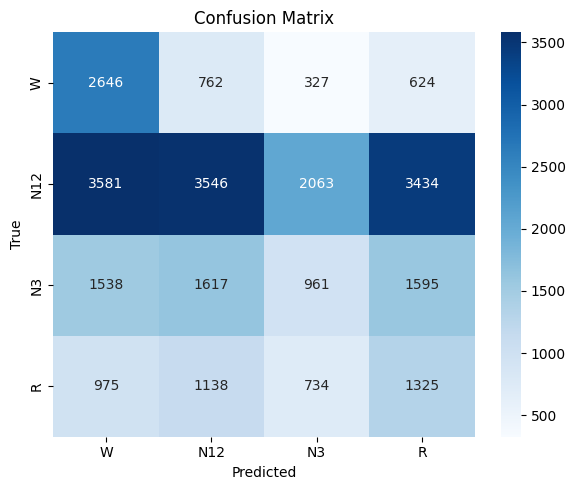

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.30      0.61      0.40      4359
         N12       0.50      0.28      0.36     12624
          N3       0.24      0.17      0.20      5711
           R       0.19      0.32      0.24      4172

    accuracy                           0.32     26866
   macro avg       0.31      0.34      0.30     26866
weighted avg       0.36      0.32      0.31     26866



In [8]:
labels = ['W', 'N12', 'N3', 'R']

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification Report
print("📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))
